In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import  MNIST
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F


## Hyperparams

In [3]:
lr = .001
batch_size = 256
in_l = 784
hid_l  =32
op_l = 10


## Downloading and splitting the data into train, test and validation sets.

In [4]:
train_ds = MNIST(root = "D:\Learning\ML\RL\TORCH\mnist_data", download=True , transform=transforms.ToTensor())
test_ds = MNIST(root = "D:\Learning\ML\RL\TORCH\mnist_data", train=False , transform=transforms.ToTensor())
train_ds , val_ds = random_split(train_ds , [50000, 10000])
len(train_ds), len(val_ds)


(50000, 10000)

## Data Loading - Splitting the data into batches

In [5]:
train_loader = DataLoader(train_ds, batch_size=batch_size,shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4 , pin_memory=True)

image shape :  torch.Size([256, 1, 28, 28])


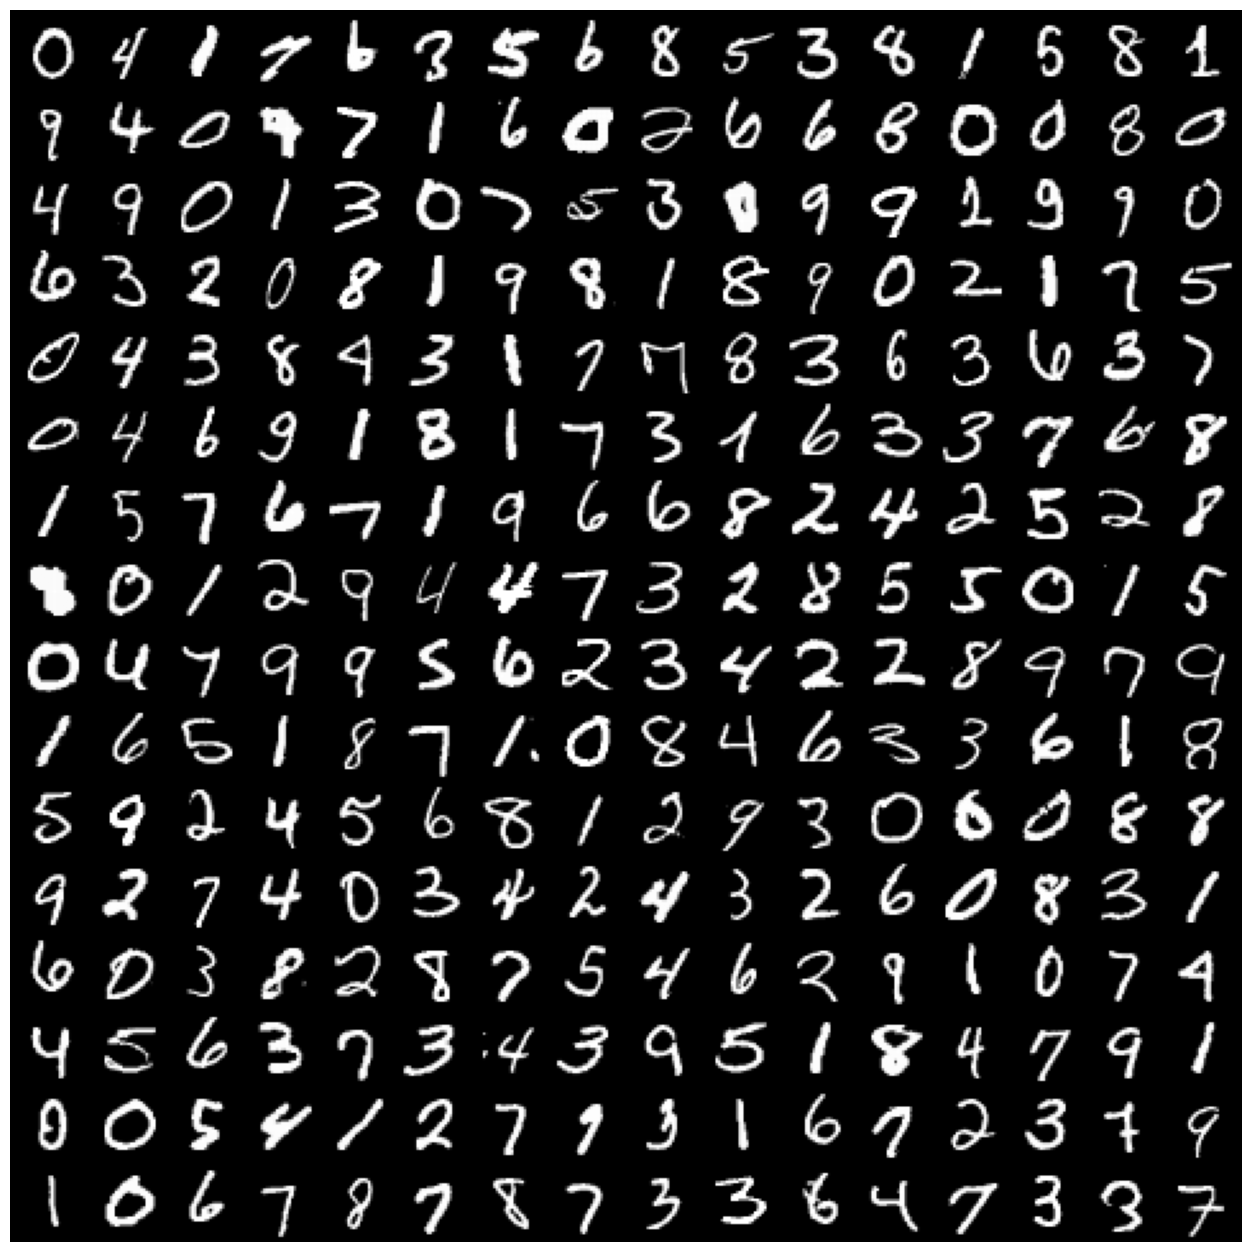

In [6]:
for images, labels in train_loader:
    print("image shape : ", images.shape)
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

## Model\

In [44]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)    
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
class MnistNN(nn.Module):
    
    def __init__(self,inp_l  , hid_l , op_l ) -> None:
        super(MnistNN, self).__init__()
        self.linear1 = nn.Linear(inp_l, hid_l)
        self.linear2 = nn.Linear(hid_l, op_l)
    # NN Layer
    def forward(self,xb):
        xb = xb.view(xb.size(0),-1)
        out = self.linear1(xb)
        out = F.relu(out)
        out= self.linear2(out)
        return out
    #LOSS for each batch     ==== returns loss
    def training_step(self, batch): 
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    #VALIDATES for each val ds each batch ==== returns loss and acc
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc=  accuracy(out, labels)
        return {"valLoss" : loss , "valAcc": acc}
    # AVG  all the LOSS and ACC for Valiadtion set  for each batch
    def validation_epoch_end(self, outputs):
        batch_loss = [X["valLoss"] for X in outputs]
        batch_acc = [X["valAcc"] for X in outputs]
        epoch_loss  = torch.stack(batch_loss).mean()
        epoch_acc  = torch.stack(batch_acc).mean()
        return {"valLoss" : epoch_loss , "valAcc" : epoch_acc}
    # AVG all the ACC and LOSS for a single EPOCH
    def epoch_end(self, epoch,result):
        print("Epoch [ {}],val_loss : {:.4f} , val_acc {:.4f}".format(epoch, result["valLoss"] , result["valAcc"]))




In [8]:
model = MnistNN(in_l,hid_l,op_l)

In [9]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


## CUDA +_+

In [10]:
torch.cuda.is_available()

True

In [11]:
#returns cuda or cpu 
def get_def_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

device = get_def_device()
device


device(type='cuda')

In [12]:
# changes to to_device
def to_device(data , device):
    if isinstance(data , (tuple, list)):
        return[to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [13]:
for images, labels in train_loader:
    print(images.shape , images.device)
    images  = to_device(images, device)
    print(images.shape , images.device)

    
    break


torch.Size([256, 1, 28, 28]) cpu
torch.Size([256, 1, 28, 28]) cuda:0


--- move the loaded data to GPU


In [14]:
class DeviceDataLoader():
    def __init__(self,dl , device):
        self.dl=dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
        

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

## Training the model

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [17]:
def fit(epochs, lr, model , train_loader , val_loader , opt_fn = torch.optim.SGD):
    history = [ ]
    optimiser = opt_fn(model.parameters(), lr)

    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        result = evaluate(model , val_loader)
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [18]:
model = MnistNN(in_l,hid_l , op_l)
to_device(model, device)

MnistNN(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [19]:
for images, labels in train_loader:
    out= model(images)
    acc = accuracy(out, labels)
    loss = F.cross_entropy(out, labels)
    break

print("loss"  ,loss.item() , "accuracy " , acc, "\n out shape  : ", out.shape, "\n sample out : " , out[:2].data)

loss 2.3253512382507324 accuracy  tensor(0.0625) 
 out shape  :  torch.Size([256, 10]) 
 sample out :  tensor([[-0.1606, -0.2201,  0.1221,  0.0316,  0.2509,  0.0831, -0.1292,  0.0519,
         -0.1560, -0.1284],
        [-0.0666, -0.1399,  0.0879, -0.0539,  0.1016,  0.0234, -0.0857,  0.2351,
         -0.2124, -0.0473]], device='cuda:0')


In [20]:
history = [evaluate (model,val_loader)]
history

[{'valLoss': tensor(2.3153, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.0908)}]

In [21]:
history += fit(5,.5,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.2965 , val_acc 0.9106
Epoch [ 1],val_loss : 0.4041 , val_acc 0.8698
Epoch [ 2],val_loss : 0.1982 , val_acc 0.9412
Epoch [ 3],val_loss : 0.1941 , val_acc 0.9429
Epoch [ 4],val_loss : 0.1849 , val_acc 0.9452


In [22]:
history += fit(7,.1,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.1538 , val_acc 0.9554
Epoch [ 1],val_loss : 0.1493 , val_acc 0.9560
Epoch [ 2],val_loss : 0.1506 , val_acc 0.9556
Epoch [ 3],val_loss : 0.1464 , val_acc 0.9563
Epoch [ 4],val_loss : 0.1456 , val_acc 0.9573
Epoch [ 5],val_loss : 0.1459 , val_acc 0.9574
Epoch [ 6],val_loss : 0.1416 , val_acc 0.9586


In [23]:
history += fit(5,.34,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.1526 , val_acc 0.9549
Epoch [ 1],val_loss : 0.1514 , val_acc 0.9566
Epoch [ 2],val_loss : 0.1410 , val_acc 0.9583
Epoch [ 3],val_loss : 0.1420 , val_acc 0.9584
Epoch [ 4],val_loss : 0.1431 , val_acc 0.9582


In [24]:
model.to('cuda')

MnistNN(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
history += fit(10,.1,model, train_loader,val_loader)


Epoch [ 0],val_loss : 0.1316 , val_acc 0.9604
Epoch [ 1],val_loss : 0.1308 , val_acc 0.9610
Epoch [ 2],val_loss : 0.1314 , val_acc 0.9618
Epoch [ 3],val_loss : 0.1323 , val_acc 0.9604
Epoch [ 4],val_loss : 0.1327 , val_acc 0.9605
Epoch [ 5],val_loss : 0.1330 , val_acc 0.9600
Epoch [ 6],val_loss : 0.1324 , val_acc 0.9605
Epoch [ 7],val_loss : 0.1297 , val_acc 0.9614
Epoch [ 8],val_loss : 0.1276 , val_acc 0.9627
Epoch [ 9],val_loss : 0.1284 , val_acc 0.9611


## Saving the model

In [26]:
torch.save(model.state_dict(), "mnist.pth")

## loading the model

In [27]:
model  = MnistNN(in_l,hid_l,op_l)
model.load_state_dict(torch.load("mnist.pth"))

<All keys matched successfully>

In [34]:
history

[{'valLoss': tensor(2.3153, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.0908)},
 {'valLoss': tensor(0.2965, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9106)},
 {'valLoss': tensor(0.4041, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.8698)},
 {'valLoss': tensor(0.1982, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9412)},
 {'valLoss': tensor(0.1941, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9429)},
 {'valLoss': tensor(0.1849, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9452)},
 {'valLoss': tensor(0.1538, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9554)},
 {'valLoss': tensor(0.1493, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9560)},
 {'valLoss': tensor(0.1506, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9556)},
 {'valLoss': tensor(0.1464, device='cuda:0', grad_fn=<MeanBackward0>),
  'valAcc': tensor(0.9563)},


Text(0, 0.5, 'Loss')

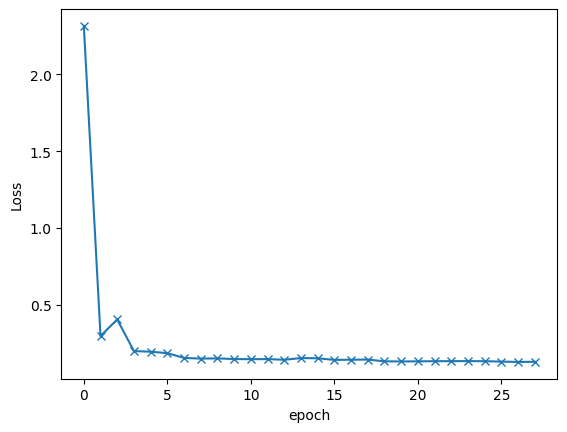

In [35]:
losses = [x["valLoss"].cpu().detach().numpy() for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

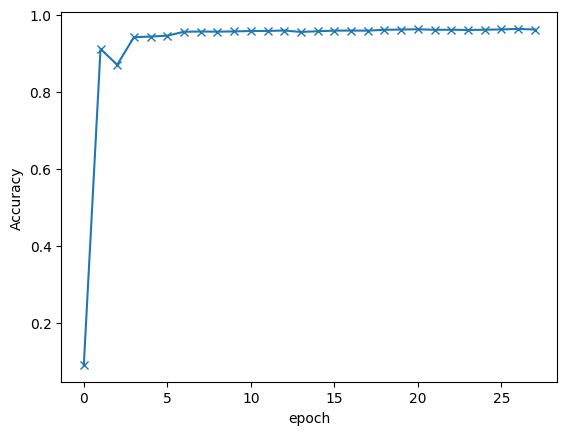

In [37]:
acc = [x["valAcc"].cpu().detach().numpy() for x in history]
plt.plot(acc, "-x")
plt.xlabel("epoch")
plt.ylabel("Accuracy")

## predict

In [45]:
model.to('cuda')

MnistNN(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [57]:
def predict(img, model):
    imge = to_device(img.unsqueeze(0),device)
    out = model(imge)
    conf,preds  = torch.max(out , dim=1)
    
    return preds[0]


In [58]:
images, labels = test_ds[0]
predict(images , model),labels

((tensor(7, device='cuda:0'),
  tensor(13.4493, device='cuda:0', grad_fn=<SelectBackward0>)),
 7)

In [62]:
lst= []
for xb in test_ds:
    images , labels  = xb
    x=predict(images,model)
    lst.append(x)

sum(lst)/len(test_ds)



TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [64]:
test_loader = DeviceDataLoader(DataLoader(test_ds,256 ,shuffle=True , num_workers=4,pin_memory=True) , device)
evaluate(model,train_loader)

{'valLoss': tensor(0.0671, device='cuda:0', grad_fn=<MeanBackward0>),
 'valAcc': tensor(0.9814)}